## Punctate metric is biases genes with fewer spots per cell to have more punctate scores

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [1]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

importlib.reload(SRRS)
importlib.reload(metrics)
importlib.reload(scoring)
importlib.reload(plotting)

sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

152

In [2]:
%%time
#fast
unfilt_cells = [c for c in sample.iter_cells() if c.n > 300]
unfilt_scored_cells = list(scoring._iter_scores(unfilt_cells, metric_name='punctate', processes=3))

len(unfilt_scored_cells)

CPU times: user 2.05 s, sys: 40.4 ms, total: 2.09 s
Wall time: 2.27 s


73

In [4]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells() if c.n > 300]

filt_cells = scoring._iter_vars(filt_cells)    
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='punctate', processes=3))

len(filt_scored_cells)

CPU times: user 2.52 s, sys: 75.5 ms, total: 2.59 s
Wall time: 1min 39s


73

In [11]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='punctate'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,punctate,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,184.0,-0.275261,0.063849
1,punctate,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,82.0,0.435540,0.044873
2,punctate,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,125.0,0.135889,0.109546
3,punctate,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,83.0,0.428571,0.167243
4,punctate,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,123.0,0.149826,0.109546
...,...,...,...,...,...,...,...,...,...
61,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,426.5,-0.106632,0.133159
62,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,217.0,0.438231,0.166883
63,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,208.0,0.461638,0.133159
64,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,207.5,0.462939,0.166883


In [5]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

,filtering,cell_id,gene,rank,m,n
0,filt,104773525917171323315032845506736864421,Cdh12,152,12,288
1,filt,104773525917171323315032845506736864421,Rorb,214,18,288
2,filt,104773525917171323315032845506736864421,Prdm8,155,7,288
3,filt,104773525917171323315032845506736864421,Cdh12,99,12,288
4,filt,104773525917171323315032845506736864421,Lsp1,15,2,288
...,...,...,...,...,...,...
81958,unfilt,98094925393968329130254909503130262661,Marcksl1,767,26,818
81959,unfilt,98094925393968329130254909503130262661,C1ql3,158,47,818
81960,unfilt,98094925393968329130254909503130262661,Sulf2,109,37,818
81961,unfilt,98094925393968329130254909503130262661,Shisa9,405,19,818


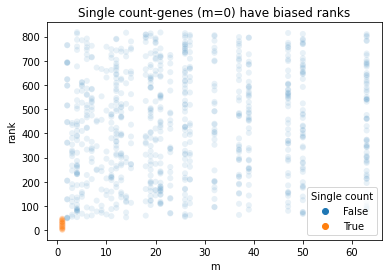

In [9]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

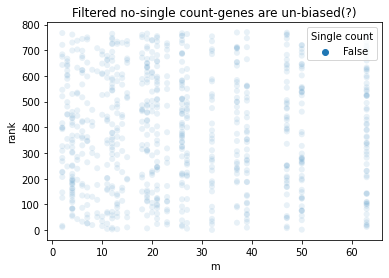

In [12]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()